# Лабораторная работа №2

Для начала импортируем необходимые библиотеки:

In [1]:
import scipy
from scipy import stats
import pandas as pd 
import math
import numpy as np
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

Для работы понядобятся Дата - '**date**', Температура - '**T**' и Давление - '**P**'. Для этого объеденим их в отдельный *DataFrame*

In [2]:
df=pd.read_csv('piter2.csv', delimiter=';', error_bad_lines=False, index_col=False)

# Переименовываем первый стобец
df.rename(columns={'Местное время в Санкт-Петербурге':'date'}, inplace=True)

# Конверитруем строковые даты в формат datetime64[ns]
df['date'] = pd.to_datetime(df['date'])

# Сортируем по дате
df = df.sort_values(by='date')

# Возмём Дату, Температуру и Давление
df = df[['date', 'T', 'P']]
df.head()

,date,T,P
2919,2018-01-01 00:00:00,0.8,756.2
2918,2018-01-01 03:00:00,0.4,755.1
2917,2018-01-01 06:00:00,0.0,753.4
2916,2018-01-01 09:00:00,-0.5,751.7
2915,2018-01-01 12:00:00,0.0,750.7


И хотя в данной выборке не наблядается пустых значений температуры и давления, но для абстрагирования от конкретных данных будем заполнять пустые данные средними по месяцу

In [3]:
columns = list(df)
columns.remove('date')

# Заполняем средними значениями
for a in columns:
    df[a].fillna(df[a].groupby([df.date.dt.year, df.date.dt.month]).transform('mean'), inplace=True)
print(df.isna().sum())
df.head()

date    0
T       0
P       0
dtype: int64


,date,T,P
2919,2018-01-01 00:00:00,0.8,756.2
2918,2018-01-01 03:00:00,0.4,755.1
2917,2018-01-01 06:00:00,0.0,753.4
2916,2018-01-01 09:00:00,-0.5,751.7
2915,2018-01-01 12:00:00,0.0,750.7


## Линейная регрессия

Общий вид Регрессионной модели:

$y = f(x,b) + \epsilon, E(\epsilon)=0$

Общий вид линейной регрессии:

$f(x,b) = b_0 + b_1x_1 + b_2x_2 + ... + b_kx_k$

где $b_{j}$ — параметры (коэффициенты) регрессии, $x_{j}$ — регрессоры (факторы модели), $k$ — количество факторов модели

У нас частный случай - $x$ это один фактор, тмпература. Поэтому формула изменяется до простейшей:

$y_t = a + bx_t + \epsilon_t$

В данной лабораторной работе будет рачитываться зависимость *температуры* от *давления*

### Ручной расчёт

Для этого необходимо найти коэфициенты *a* и *b*. Находим их с помощью **метода наименьших квадратов** (**МНК**)

$ b = \frac { \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) } {\sum_{i=1}^n (x_i - \bar{x})^2}$

$a = \bar{y} - b\bar{x} $

In [4]:
test = df.groupby([df.date.dt.month, df.date.dt.day])
a, b = test.T.mean(), test.P.mean()
test_df = a.to_frame().join(b.to_frame())
test_df

T         P
date date                   
1    1      0.5125  751.6375
     2     -8.5750  756.6000
     3    -15.1375  778.0625
     4      0.1375  759.5250
     5      7.2875  759.2500
...            ...       ...
12   27    -3.1875  757.1125
     28    -1.8125  757.9750
     29    -1.0500  761.0250
     30     0.2125  759.6750
     31    -1.6250  766.8750

[365 rows x 2 columns]

In [5]:
test_df = df[df.date.dt.month == 3]

In [6]:
test_df = test_df.sort_values(by='T')
X = np.array(test_df['T'])
Y = np.array(test_df['P'])
m = len(X)
mean_x = X.mean()
mean_y = Y.mean()
print("Среднее значение температуры 'T': {}, \nСреднее значение двления 'P': {}\n".format(mean_y, mean_x))
numer = sum((X - mean_x) * (Y - mean_y))
denom = sum((X - mean_x) ** 2)
b = numer / denom
a = mean_y - (b * mean_x)
print ("b = {}; a = {};".format(b, a))

Среднее значение температуры 'T': 757.4411290322581, 
Среднее значение двления 'P': 0.9342741935483873

b = 0.006785530251029144; a = 757.4347894864551;


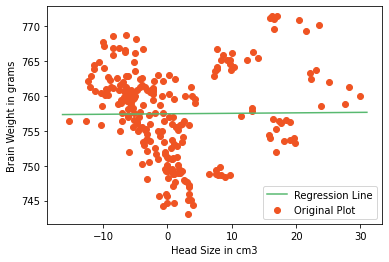

In [37]:
max_x = np.max(X) + 1
min_x = np.min(X) - 1

x = np.linspace(min_x, max_x, 1000)
y = a + b * x

plt.plot(x, y, color='#58b970', label='Regression Line')
# Ploting Scatter Points
plt.scatter(X, Y, color='#ef5423', label='Original Plot')

plt.xlabel('Head Size in cm3')
plt.ylabel('Brain Weight in grams')
plt.legend()
plt.show()

In [8]:
rmse = 0
for i in range(m):
    y_pred = a + b * X[i]
    rmse += (Y[i] - y_pred) ** 2
rmse = np.sqrt(rmse/m)
print('RMSE ручная:', rmse)

RMSE ручная: 6.298325613939896


In [9]:
ss_t = 0
ss_r = 0
for i in range(m):
    y_pred = a + b * X[i]
    ss_t += (Y[i] - mean_y) ** 2
    ss_r += (Y[i] - y_pred) ** 2
r2 = 1 - (ss_r/ss_t)
print("R2 ручная:", r2)

R2 ручная: 9.268509388360435e-05


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# X and Y Values
X = X.reshape((-1, 1))
# Y = np.array(write)

# Model Intialization
reg = LinearRegression()
# Data Fitting
reg = reg.fit(X, Y)
# Y Prediction
Y_pred = reg.predict(X)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = reg.score(X, Y)

print("Rmse автоматическое:", rmse)
print("R2 автоматическое:", r2)

Rmse автоматическое: 6.298325613939897
R2 автоматическое: 9.268509388316026e-05


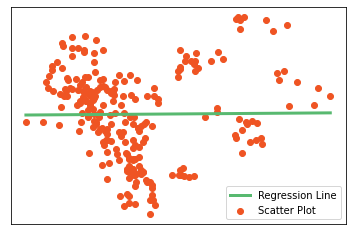

In [11]:
plt.scatter(X, Y, color='#ef5423', label='Scatter Plot')
plt.plot(X, Y_pred, color='#58b970', label='Regression Line', linewidth=3)

plt.xticks(())
plt.yticks(())
plt.legend()
plt.show()

## Авторегрессия

Буду испольовать ARIMA

In [141]:
import re
import calendar
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, pacf, acf
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [163]:
new_df2 =  df[df.date.dt.month == 3]
new_df2 = new_df2

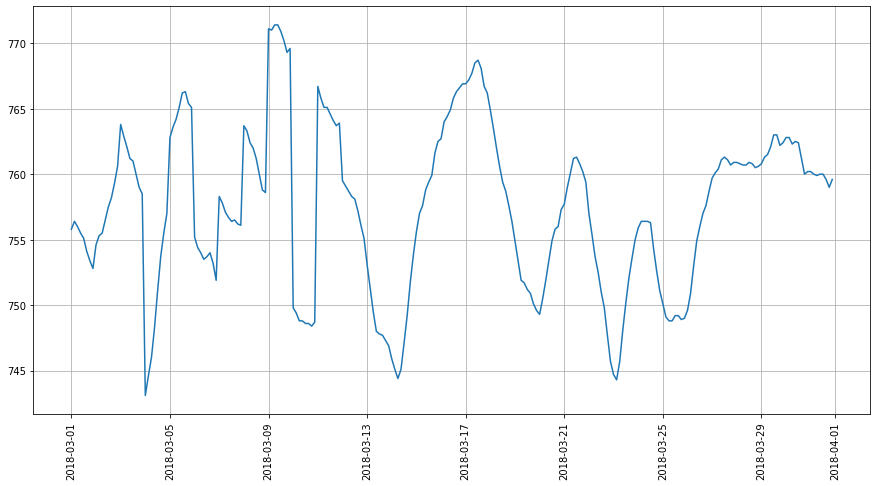

In [164]:
column = 'P'
plt.figure(figsize=[15,7.5])
plt.plot(new_df2['date'],new_df2[column])
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

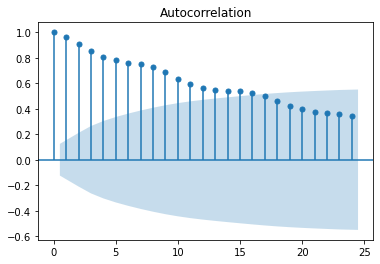

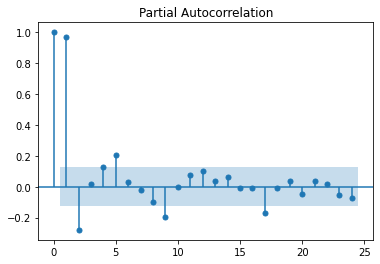

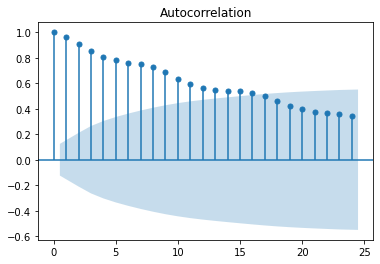

In [165]:
plot_pacf(new_df2['T'])
plot_acf(new_df2['T'])

In [166]:
res=adfuller(new_df2[column])
print('ADF =',res[0])
print('pvalue =',res[1])
##Так как pvalue < 0.05 то это означает что ряд стационарен 

ADF = -3.338295149777936
pvalue = 0.013251085037314415


$pvalue < 0.05$ Что хорошо - ряд Стационарен и с ним можно продолжать работать

Однако для улучшения данны прологарифмируем их и сделает один вычет

In [167]:
new_df2[column]=np.log(new_df2[column])

In [168]:
#plt.figure(figsize=[15,7.5])
#plt.plot(new_df2['date'],new_df2['P'])
#plt.xticks(rotation=90)
#plt.grid(True)


In [169]:
new_df2[column]=new_df2[column].diff()
new_df2=new_df2.drop(new_df2.index[0])

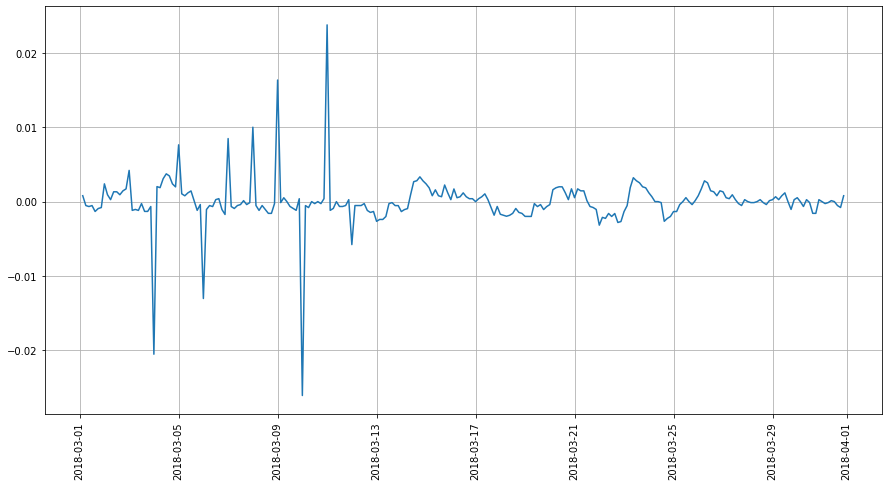

In [170]:
plt.figure(figsize=[15,7.5])
plt.plot(new_df2['date'],new_df2[column])
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [171]:
res=adfuller(new_df2[column])
print('ADF=',res[0])
print('pvalue=',res[1])

ADF= -8.948265784405324
pvalue= 8.86622107973197e-15


$pvalue < 0.05$ И стал ещё меньше. Сами данные приняли более приемлимый видл для исследования

In [172]:
#plot_pacf(new_df2['P'])
#plot_acf(new_df2['P'])

In [173]:
from tqdm import tqdm_notebook
def optimizeARIMA(order_list,exog):
    results=[]
    for order in tqdm_notebook(order_list):
        try:
            model=SARIMAX(exog,order=order).fit(disp=-1)
        except:
            continue
        aic=model.aic
        results.append((order,model.aic))
    result_df=pd.DataFrame(results)
    result_df.columns=['p,d,q','aic']
    result_df=result_df.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_df

Используем диапазон от 0 до 8, при d = 1

In [174]:
from itertools import product
ps=range(0,8,1)
qs=range(0,8,1)
d=1
parametrs=product(ps,qs)
plist=list(parametrs)
plist
olist=[]
# перебор (p,d,q)
for p in plist:
    p=list(p)
    p.insert(1,1)
    p=tuple(p)
    olist.append(p)
olist
result_df=optimizeARIMA(olist, exog = new_df2[column])



  0%|          | 0/64 [00:00<?, ?it/s]

**aic** - информационный критерий модели

In [175]:
result_df

,"p,d,q",aic
0,"(7, 1, 5)",-2110.963142
1,"(7, 1, 7)",-2104.083145
2,"(1, 1, 2)",-2098.662105
3,"(4, 1, 3)",-2098.242769
4,"(3, 1, 5)",-2095.866599
...,...,...
59,"(5, 1, 1)",-2053.515087
60,"(2, 1, 0)",-2047.834401
61,"(6, 1, 1)",-2040.138441
62,"(1, 1, 0)",-2024.828183


In [114]:
new_df2 =  df[df.date.dt.month == 3]
new_df2 = new_df2

In [176]:
train = new_df2[column][:len(new_df2[column]) - 100]
test = new_df2[column][len(new_df2[column]) - 100:]
size = len(new_df2[column]) - 100
best_model=SARIMAX(train, order=(7,1,5)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      P   No. Observations:                  147
Model:               SARIMAX(7, 1, 5)   Log Likelihood                 594.888
Date:                Sun, 27 Dec 2020   AIC                          -1163.776
Time:                        19:09:15   BIC                          -1124.989
Sample:                             0   HQIC                         -1148.016
                                - 147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7213      0.722     -0.999      0.318      -2.137       0.694
ar.L2         -0.4509      1.007     -0.448      0.654      -2.424       1.522
ar.L3         -0.2345      0.946     -0.248      0.8

In [177]:
ljung_box, p = acorr_ljungbox(best_model.resid)
print(p)

[9.44537707e-02 7.55200746e-02 1.46693580e-01 2.26005158e-01
 3.15479994e-01 9.36563035e-02 2.46833326e-02 4.42403994e-05
 7.11659671e-05 1.28031200e-04 2.53660830e-04 4.72732018e-04
 8.50894021e-04 1.24480855e-03 1.38321602e-03 1.47975816e-03
 2.24517052e-03 3.53375230e-03 5.10081810e-03 7.39281483e-03
 1.06737334e-02 1.52433594e-02 2.06812982e-02 1.53188428e-02
 1.86138745e-02 2.22738888e-02 2.99338286e-02 3.94713786e-02
 5.08617657e-02 6.27821926e-02 7.02709610e-02 7.40662587e-02
 7.73282126e-02 8.45717510e-02 9.95637949e-02 1.16661784e-01
 1.39965533e-01 1.63064358e-01 1.75531802e-01 5.43591301e-03]


## Предсказание в ARIMA

In [178]:
predictions = best_model.predict(start = size, end=size + 99)
forecast_1= best_model.forecast(steps=1)
act= pd.DataFrame(test)
print(act)
predictions=pd.DataFrame(predictions)
print(predictions)

             P
2299 -0.000665
2298 -0.000399
2297 -0.001066
2296 -0.000667
2295 -0.000400
...        ...
2204  0.000132
2203  0.000000
2202 -0.000526
2201 -0.000790
2200  0.000790

[100 rows x 1 columns]
     predicted_mean
147       -0.001040
148       -0.001341
149       -0.001050
150       -0.001099
151       -0.001011
..              ...
242       -0.000818
243       -0.000818
244       -0.000818
245       -0.000818
246       -0.000818

[100 rows x 1 columns]


,Pred,Actual
2299,-0.001040,-0.000665
2298,-0.001341,-0.000399
2297,-0.001050,-0.001066
2296,-0.001099,-0.000667
2295,-0.001011,-0.000400


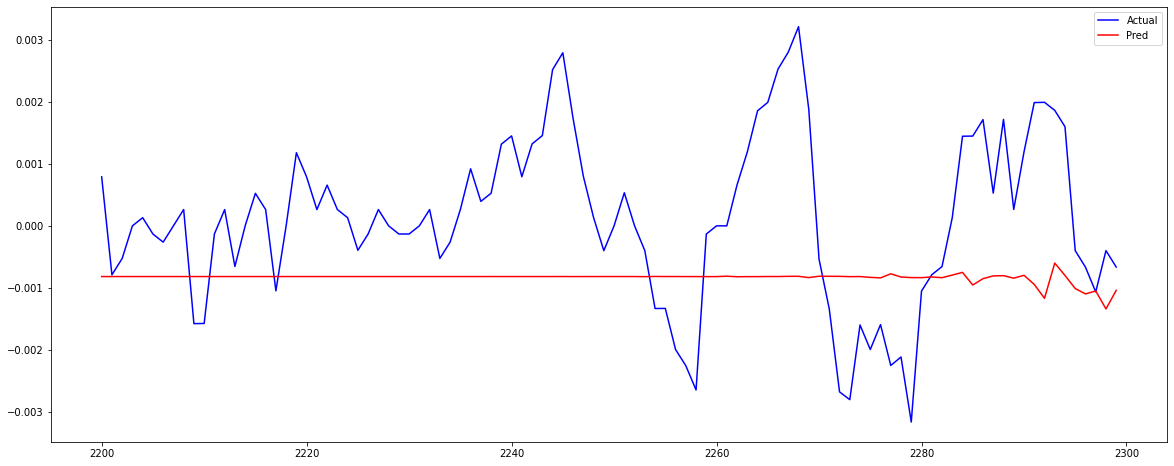

In [179]:
predictions.index=test.index
predictions['Actual'] = act[column]
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
predictions.head()

In [46]:
start_index = 3
end_index = 7
forecast = best_model.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
print("Предсказанное:")
for yhat in forecast:
    print(yhat * 100)
print("Изначальное:")
for x in new_df2['P'][3:8]:
    print(x * 100)

Предсказанное:
-0.0059863754426350444
-0.025786879535518607
-0.056541124322646116
-0.020785703584186983
-0.056228854765383654
Изначальное:
-0.052959090341442305
-0.1325205600778645
-0.0928689950661088
-0.0796706986770701
0.238821925904098


In [34]:
new_df2['P']

2902    0.000794
2901   -0.000529
2900   -0.000662
2899   -0.000530
2898   -0.001325
          ...   
2204    0.000132
2203    0.000000
2202   -0.000526
2201   -0.000790
2200    0.000790
Name: P, Length: 247, dtype: float64

In [35]:
new_df2['P'][3:10]

2899   -0.000530
2898   -0.001325
2897   -0.000929
2896   -0.000797
2655    0.002388
2654    0.000927
2653    0.000265
Name: P, dtype: float64

In [29]:
#test =  df[df.date.dt.month == 3]
##test = [x for x in test['P']]
#print(test)
#output = best_model.forecast()
#print(output)
#predictions = list()
#for t in range(len(test)):
#    output = best_model.forecast()
#    yhat = output
#    print('Предсказано = %f, Ожидалось = %f' % (yhat, t))